## Теоретическая часть

#### 1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  В чем принципиальные отличия item-item рекомендаций от ALS?

User-User рекомендации основаны на анализе предпочтений групп пользователей со схожими интересами (при естественном предположении о консервативности пользовательских предпочтений). Item-Item рекомендации основаны на анализе взаимосвязей между объектами. В User-User рекомендации определяется сходство между пользователями и в качестве рекомендаций пользователю выдается n самых часто покупаемых товаров k наиболее похожими на него покупателями. Основная идея Item-Item рекомендации заключается
в группировке информационных единиц (товары, услуги, действия) имеющих сходные оценки пользователей. Рекомендации
вырабатываются по следующему принципу: пользователю оценившему объект X высоко будет предложен объект Y, который высоко оценили
другие пользователи, также высоко оценившие и объект X. У этих методов похожие алгоритмы выдачи рекомендаций.

В методе User-User, т.к. каждый пользователь взаимодействовал только с несколькими элементами, это делает метод довольно чувствительным к любым зарегистрированным взаимодействиям (высокая дисперсия). С другой стороны, мы получаем более персонализированные результаты. Этот метод чувствителен к холодному старту (новые объекты никому не рекомендуются) и метод не может ничего рекомендовать новым пользователям.

В методе Item-Item, т.к. многие пользователи взаимодействуют с элементом, поиск окрестностей менее чувствителен к отдельным взаимодействиям (более низкая дисперсия). Взаимодействия, исходящие от всех типов пользователей (даже пользователей, очень отличающихся от нашего эталонного пользователя), рассматриваются в рекомендации, что делает метод менее персонализированным. Таким образом, этот подход менее персонализирован, чем подход User-User, но более надежен. Этот метод так же чувствителен к холодному старту при этом рекомендации становятся тривиальными.

Функцию item_item_rec(interaction_matrix) можно использовать для user_user_rec добавляя в рекомендации вместе с товарами других пользователей и близкие к ним товары. Т.е. находим сначала похожих пользователей методом User-User , смотрим какие они товары покупали. Затем по товарам методом Item-Item находим похожие товары и рекомедуем их. 

Метод Item-Item дает рекомендации основанные на анализе взаимосвязей между объектами, используя неизменённую матрицу user_item_matrix. ALS - берёт user_item_matrix, приближенно факторизует её на две матрицы: матрицу факторов пользователей и матрицу факторов товаров. Рекомендации основываются на изменённой матрице user_item_matrix, которая получается как результат перемножения матриц факторов пользователей и факторов товаров.


#### 2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 

бинарные веса - купил/не купил,
максимальное число покупок, среднее число покупок, 
средняя сумма покупок, максимальная сумма покупок, нормированная сумма покупок ((x-min)/(max-min))

#### 3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)

Тип данных в матрице Cui - float. Пропуски в матрице заменяются нулями, что не вполне адекватно.
Если матрица Cui будет иметь высокий ранг, то сильного снижения размерности мы не получим.

ALS - это фактически множественная гребневая регрессия (регуляризация L2 приводит к тому, что ни один из коэффициентов не становится нулевым,  L1 регуляризаторы гарантируют отсутствие мультиколлинеарности и переобучения). Вычисление значений - линейно, т.к это умножение матриц.

## Практическая часть


In [125]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    recommended_list = recommended_list[:k]
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
   
    return precision

In [126]:
data = pd.read_csv('retail_train.csv')

In [127]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.shape[0], data_test.shape[0]

(2278490, 118314)

In [128]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
...,...,...
2037,2496,[6534178]
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ..."
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972..."
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813..."


In [129]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999
data_train.item_id.nunique()

5001

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [130]:
# c_ui словарь, содержащий различные матрицы весов
c_ui = dict()

# Для создания матрицы C_ui_quant_count используем функцию агрегации count, агрегацию производим по столбцу quantity  
c_ui_quant_count = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', 
                                  aggfunc='count', 
                                  fill_value=0
                                 )

c_ui_quant_count = c_ui_quant_count.astype(float) # необходимый тип матрицы для implicit

c_ui['quant_count'] = c_ui_quant_count

# Для создания матрицы C_ui_quant_max используем функцию агрегации max, агрегацию производим по столбцу quantity  
c_ui_quant_max = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', 
                                  aggfunc='max', 
                                  fill_value=0
                                 )

c_ui_quant_max = c_ui_quant_max.astype(float) # необходимый тип матрицы для implicit

c_ui['quant_max'] = c_ui_quant_max

# Для создания матрицы C_ui_quant_mean используем функцию агрегации mean, агрегацию производим по столбцу quantity  
c_ui_quant_mean = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', 
                                  aggfunc='mean', 
                                  fill_value=0
                                 )

c_ui_quant_mean = c_ui_quant_mean.astype(float) # необходимый тип матрицы для implicit

c_ui['quant_mean'] = c_ui_quant_mean

c_ui_quant_count.shape

(2499, 5001)

In [131]:
# Для создания матрицы C_ui_sales_max используем функцию агрегации max, агрегацию производим по столбцу sales_value  
c_ui_sales_max = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', 
                                  aggfunc='max', 
                                  fill_value=0
                                 )

c_ui_sales_max = c_ui_sales_max.astype(float) # необходимый тип матрицы для implicit

c_ui['sales_max'] = c_ui_sales_max

# Для создания матрицы C_ui_sales_mean используем функцию агрегации mean, агрегацию производим по столбцу sales_value  
c_ui_sales_mean = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', 
                                  aggfunc='mean', 
                                  fill_value=0
                                 )

c_ui_sales_mean = c_ui_sales_mean.astype(float) # необходимый тип матрицы для implicit

c_ui['sales_mean'] = c_ui_sales_mean
c_ui_sales_mean.shape

(2499, 5001)

In [132]:
userids = c_ui_sales_mean.index.values
itemids = c_ui_sales_mean.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [133]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_user_item.tocsr(),   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)]
    return res

In [134]:
%%time

for key in c_ui:
    csr_user_item = csr_matrix(c_ui[key])
    model = AlternatingLeastSquares(factors=44, 
                                    regularization=0.001,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    use_gpu=False)

    model.fit(csr_user_item.T.tocsr(), show_progress=True)
    result[key] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))



Wall time: 1min 25s


In [135]:
result.head(5)

,user_id,actual,quant_count,quant_max,quant_mean,sales_max,sales_mean
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1005186, 885290, 1033142, 5569374, 995242]","[820165, 1082185, 866227, 995242, 1127831]","[866227, 1082185, 820165, 1095275, 986947]","[986912, 1100972, 1005186, 1082185, 5569374]","[1005186, 1082185, 1100972, 1021164, 10149640]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 822407, 1133018, 951590, 892008]","[951590, 1022003, 910032, 938700, 913202]","[1022003, 938700, 1013321, 1092026, 6534178]","[5569230, 5569845, 1133018, 910032, 951590]","[5569230, 910032, 1044078, 1029743, 914190]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[878996, 1024306, 860776, 1023720, 866211]","[878996, 1024306, 1082185, 1007195, 1127831]","[1082185, 1127831, 878996, 820165, 1024306]","[1024306, 948953, 1007195, 896613, 1082185]","[970747, 1024306, 965267, 1082185, 866211]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[849843, 1082185, 1126899, 1058997, 6534178]","[938700, 1082185, 1013321, 995242, 892920]","[938700, 995242, 1013321, 1082185, 826249]","[1082185, 6534178, 916122, 866211, 1127831]","[1082185, 866211, 916122, 1020581, 847573]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1053690, 1070820, 844179, 840361, 981760]","[833715, 930917, 826249, 1068719, 883404]","[833715, 844179, 951526, 1082185, 859075]","[1005186, 999858, 844179, 897954, 1110843]","[1005186, 844179, 1051211, 999858, 5569230]"


##### сравним качество предсказаний по precision@5 для разных $C_{ui}$

In [136]:
precision = dict()
for key in c_ui:
    precision[key] = result.apply(lambda row: precision_at_k(row[key], row['actual']), axis=1).mean()

precision

{'quant_count': 0.18413320274240713,
 'quant_max': 0.1866797257590568,
 'quant_mean': 0.18824681684622643,
 'sales_max': 0.14250734573946947,
 'sales_mean': 0.13868756121449427}

Матрица $C_{ui}$, построенная с использованием агрегатной функции mean по столбцу quantity, показала лучшее качество. Эту матрицу мы возьмем для дальнейшей оптимизации гиперпараметров.

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [137]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
...,...,...
2037,2496,[6534178]
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ..."
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972..."
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813..."


In [139]:
import time

csr_user_item = csr_matrix(c_ui['quant_mean'])

factors = [35, 45, 55, 80, 100]
regularization = [0.001, 0.01, 0.1, 1]
timer = dict()

for factor in factors:
    for lambda_ in regularization:
        start_time = time.time()
        model = AlternatingLeastSquares(factors=factor, 
                                        regularization=lambda_,
                                        iterations=15, 
                                        calculate_training_loss=True, 
                                        use_gpu=False)

        model.fit(csr_user_item.T.tocsr(), show_progress=True)
        timer[f'{factor}_{lambda_}'] = time.time() - start_time
        result[f'{factor}_{lambda_}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    


35 0.001



35 0.01



35 0.1



35 1



45 0.001



45 0.01



45 0.1



45 1



55 0.001



55 0.01



55 0.1



55 1



80 0.001



80 0.01



80 0.1



80 1



100 0.001



100 0.01



100 0.1



100 1


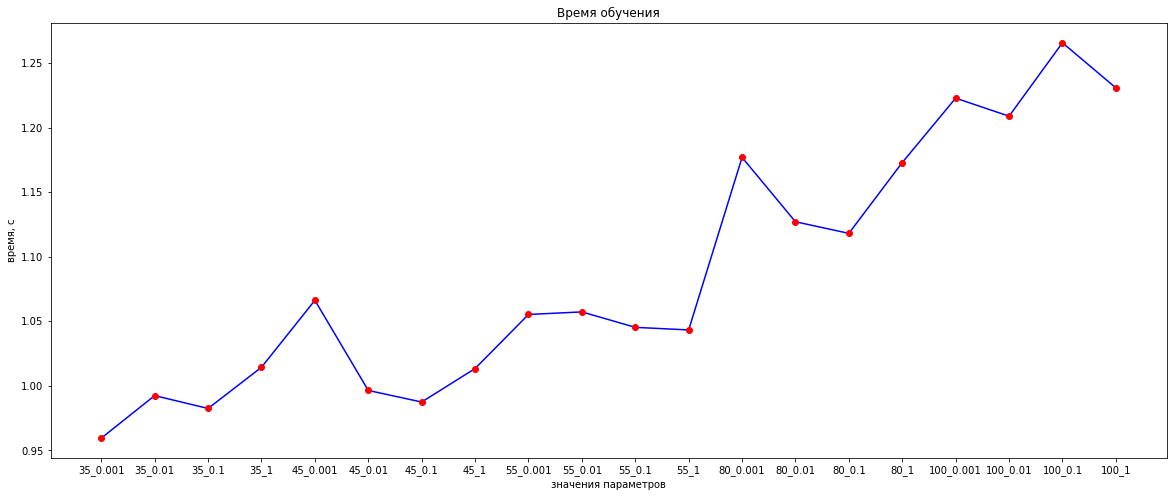

In [149]:
labels = list(timer.keys())
times = list(timer.values()) 

plt.figure(figsize=(20, 8))
plt.title('Время обучения')
plt.xlabel('значения параметров')
plt.ylabel('время, с')
plt.plot(labels, times, 'b')
plt.plot(labels, times, 'ro')
plt.show()

In [150]:
result.head(3)

,user_id,actual,35_0.001,35_0.01,35_0.1,35_1,45_0.001,45_0.01,45_0.1,45_1,...,55_0.1,55_1,80_0.001,80_0.01,80_0.1,80_1,100_0.001,100_0.01,100_0.1,100_1
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 995242, 986947, 981760, 1127831]","[1082185, 1127831, 995242, 820165, 866227]","[986947, 1082185, 866227, 995242, 1127831]","[986947, 1082185, 820165, 1127831, 981760]","[820165, 986947, 1082185, 866227, 1127831]","[1082185, 995242, 986947, 866227, 907014]","[820165, 1082185, 866227, 986947, 995242]","[1082185, 820165, 1127831, 986947, 981760]",...,"[866227, 1005186, 1082185, 820165, 986947]","[1082185, 995242, 1127831, 820165, 986947]","[820165, 995242, 986947, 866227, 1082185]","[1082185, 820165, 986947, 1095275, 866227]","[820165, 1082185, 986947, 1005186, 1127831]","[820165, 1082185, 986947, 866227, 1127831]","[820165, 995242, 986947, 1082185, 907014]","[820165, 986947, 1082185, 995242, 866227]","[986947, 820165, 995242, 866227, 1082185]","[820165, 986947, 866227, 907014, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[938700, 822407, 1022003, 6534178, 929668]","[938700, 1013321, 822407, 1022003, 844165]","[1022003, 822407, 938700, 844165, 1092026]","[862139, 833715, 951590, 6534178, 910032]","[1013321, 938700, 951590, 852864, 1022003]","[844165, 929668, 938700, 1022003, 1092026]","[938700, 889774, 852864, 910032, 1022003]","[938700, 1022003, 6534178, 822407, 1013321]",...,"[938700, 1055863, 910032, 1133018, 951590]","[1022003, 9526563, 1055863, 938700, 6534178]","[1106523, 1133018, 1022003, 938700, 9337581]","[1022003, 951590, 938700, 1044078, 914190]","[1106523, 1133018, 951590, 9337581, 1022003]","[938700, 1106523, 1133018, 8090521, 1022003]","[9337581, 951590, 1022003, 910032, 938700]","[1022003, 910032, 938700, 1106523, 1044078]","[1133018, 1106523, 938700, 1022003, 910032]","[1133018, 938700, 1106523, 1044078, 1022003]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 878996, 1024306, 1127831, 820165]","[1082185, 878996, 1024306, 1127831, 820165]","[1082185, 1127831, 820165, 860776, 878996]","[1082185, 866227, 860776, 1127831, 878996]","[1082185, 1024306, 1127831, 878996, 860776]","[1082185, 878996, 911878, 820165, 1024306]","[1082185, 1024306, 1127831, 878996, 860776]","[1082185, 1024306, 878996, 1127831, 820165]",...,"[1082185, 878996, 1127831, 1024306, 860776]","[1082185, 820165, 1127831, 878996, 860776]","[878996, 1024306, 1127831, 1082185, 968215]","[1082185, 1127831, 878996, 866211, 1024306]","[1082185, 878996, 1127831, 1024306, 866211]","[1082185, 820165, 1127831, 878996, 1007195]","[1082185, 1024306, 1127831, 878996, 866211]","[1082185, 1127831, 878996, 981760, 834484]","[1082185, 878996, 820165, 981760, 994928]","[878996, 1082185, 860776, 1024306, 1127831]"


In [152]:
# посчитаем точность для каждого из полученных предсказаний
precision = dict()
for factor in factors:
    for lambda_ in regularization:
        precision[f'{factor}_{lambda_}'] = \
                  result.apply(lambda row: precision_at_k(row[f'{factor}_{lambda_}'], row['actual']), axis=1).mean()

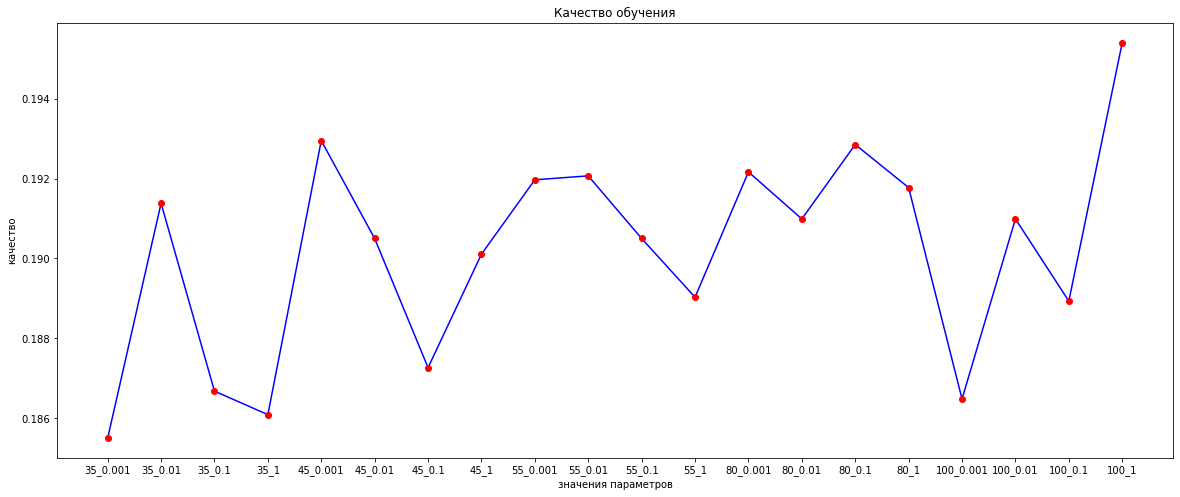

In [154]:
labels = list(precision.keys())
values = list(precision.values())        

plt.figure(figsize=(20, 8))
plt.title('Качество обучения')
plt.xlabel('значения параметров')
plt.ylabel('качество')
plt.plot(labels, values, 'b')
plt.plot(labels, values, 'ro')
plt.show()

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

Время обучения растет с ростом количества факторов. Для каждого значения фактора имеем всплеск увеличения скорости при лямбда равном 0,001. Высокие значения точности также имеем при лямбда равном 0,001 для количества факторов 35, 45, 55. Для количества факторов 80 и 100 имеем переобучение (лямбда смещается в 0,1 и 1 для максимальных значений).  

In [159]:
#максимальное значение точности достигаем при lambda=0.001  и количестве факторов равном 45
precision['45_0.001']

0.1929480901077348